In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#read in all tables first
user = pd.read_csv("user_table.csv")
homepage = pd.read_csv("home_page_table.csv")
searchpage = pd.read_csv("search_page_table.csv")
payment = pd.read_csv("payment_page_table.csv")
confirmation = pd.read_csv("payment_confirmation_table.csv")

In [3]:
print("user table has shape: ", user.shape)
print("homepage table has shape: ", homepage.shape)
print("searchpage table has shape: ", searchpage.shape)
print("payment page table has shape: ", payment.shape)
print("confirmation page table has shape: ", confirmation.shape)

user table has shape:  (90400, 4)
homepage table has shape:  (90400, 2)
searchpage table has shape:  (45200, 2)
payment page table has shape:  (6030, 2)
confirmation page table has shape:  (452, 2)


In [4]:
#join all tables
#be careful to only inner join user and homepage, and left join user and other tables
user = pd.merge(user, homepage, how='inner', on = 'user_id')
user = pd.merge(user, searchpage, how = 'left', on = 'user_id', suffixes=['_home', '_search'])
user = pd.merge(user, payment, how = 'left', on = 'user_id')
user = pd.merge(user, confirmation, how = 'left', on = 'user_id', suffixes=['_payment', '_payment_confirmation'])

In [5]:
#full table is ready
user.head(3)

,user_id,date,device,sex,page_home,page_search,page_payment,page_payment_confirmation
0,450007,2015-02-28,Desktop,Female,home_page,NaN,NaN,NaN
1,756838,2015-01-13,Desktop,Male,home_page,NaN,NaN,NaN
2,568983,2015-04-09,Desktop,Male,home_page,search_page,NaN,NaN


## Two goals

1. full picture of funnel conversion rate for both desktop and mobile
2. what could be done to improve conversion rate

## Analysis of conversion rate for desktop and mobile

We can see that the distribution of *Desktop*:*Mobile* is almost *2:1*

In [6]:
#groupby device and check out conversion number
device = user.groupby(['device'])['page_home', 'page_search','page_payment','page_payment_confirmation'].count()
device

,page_home,page_search,page_payment,page_payment_confirmation
device,,,,
Desktop,60200,30100,3010,150
Mobile,30200,15100,3020,302


Based on below table, we find out that 
1. half of both desktop and mobile users go from home page to search page
2. percentage of mobile users who go to payment page is twice that of desktop users
3. percentage of mobile users who confirm payment is four times that of desktop users

**Therefore, problem is very likely caused by some errors on the website for PC users**

In [7]:
#check out conversion rate of each device by dividing page_home number
device_conversion = device[['page_search','page_payment','page_payment_confirmation']].apply(lambda x: x / device['page_home'])
device_conversion

,page_search,page_payment,page_payment_confirmation
device,,,
Desktop,0.5,0.05,0.002492
Mobile,0.5,0.10,0.010000


## More analysis to dig out other problems

1. check out if sex affects conversion rate
2. check out relationship between date and conversion rate

**SEX** <br/>Based on tables below, we find out that females are slightly more likely to convert than males. But the difference is not large <br/> For product team, they need to think about how to improve conversion rate of males, perhaps adding some features that could attract males

In [8]:
sex = user.groupby(['sex'])['page_home', 'page_search','page_payment','page_payment_confirmation'].count()
sex

,page_home,page_search,page_payment,page_payment_confirmation
sex,,,,
Female,45075,22676,3100,241
Male,45325,22524,2930,211


In [9]:
sex_conversion = sex[['page_search','page_payment','page_payment_confirmation']].apply(lambda x: x / sex['page_home'])
sex_conversion

,page_search,page_payment,page_payment_confirmation
sex,,,
Female,0.503073,0.068774,0.005347
Male,0.496944,0.064644,0.004655


**DATE**<br/> conversion rate at each step of the page varies day by day. And on 2015-03-01, nobody makes payment. This could be a bug or an error made on 2015-03-01, or the site might be down on that date<br/> Product team needs to make sure with engineering team that this kind of bugs should never appear again

In [10]:
date = user.groupby(['date'])['page_home', 'page_search','page_payment','page_payment_confirmation'].count()
date.head()

,page_home,page_search,page_payment,page_payment_confirmation
date,,,,
2015-01-01,712,436,76,6
2015-01-02,721,447,84,5
2015-01-03,760,422,64,7
2015-01-04,713,447,76,7
2015-01-05,754,462,88,11


In [11]:
date_conversion = date[['page_search','page_payment','page_payment_confirmation']].apply(lambda x: x / date['page_home'])
date_conversion.head()

,page_search,page_payment,page_payment_confirmation
date,,,
2015-01-01,0.612360,0.106742,0.008427
2015-01-02,0.619972,0.116505,0.006935
2015-01-03,0.555263,0.084211,0.009211
2015-01-04,0.626928,0.106592,0.009818
2015-01-05,0.612732,0.116711,0.014589


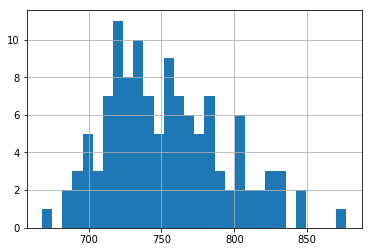

In [12]:
#on most dates, site visits range from 680 - 850. Only few dates of outliers
date['page_home'].hist(bins=30)

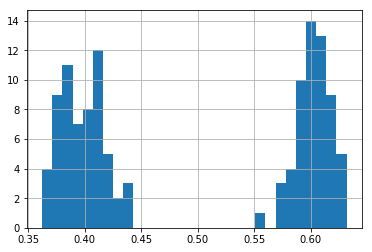

In [13]:
#very interestingly, page search conversion rate is either >0.55 or <0.44
date_conversion['page_search'].hist(bins = 30)

In [21]:
## find out the date at which payment confirmation page rate is the highest and lowest
max_date = date_conversion['page_payment_confirmation'].idxmax()
min_date = date_conversion['page_payment_confirmation'].idxmin()
print("max_date: {} has conversion rate {}".format(max_date, date_conversion.loc[max_date, 'page_payment_confirmation']))
print("min_date: {} has conversion rate {}".format(min_date, date_conversion.loc[min_date, 'page_payment_confirmation']))

max_date: 2015-01-05 has conversion rate 0.014588859416445624
min_date: 2015-03-01 has conversion rate 0.0


In [29]:
date.loc[min_date, :]

page_home                    722
page_search                  283
page_payment                  19
page_payment_confirmation      0
Name: 2015-03-01, dtype: int64

In [28]:
date_conversion.loc[min_date,:]

page_search                  0.391967
page_payment                 0.026316
page_payment_confirmation    0.000000
Name: 2015-03-01, dtype: float64